In [37]:
import pandas as pd
import numpy as np
import math
import statistics
import datetime as dt
import warnings
import time
from matplotlib import pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest, ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import eli5
from eli5.sklearn import PermutationImportance


In [19]:
#load data
pd.set_option('display.max_columns', None)
df = pd.read_csv('imputed_revent.csv')
df = df.drop(axis=1, columns=['Unnamed: 0','last_careunit'])

## 1: Post-pre-processing

#### 1.1: Variable grouping

In [21]:
# variables for analysis
categorical = ['ethnicity', 
              'marital_status',
              'language',
              'admission_location',
              'gender',
              'insurance',
              'first_careunit',
              'admission_type']
proceduretype=['aortic','mit','tricuspid','pulmonary','cabg']
ptParams = ['weight', 'height', 'bmi']
boolFields = ['reintubation', 'liver_severe', 'liver_mild', 'rheum', 'cvd', 'aids', 'ckd', 'copd', 'arrhythmia', 'pud', 'smoking', 'pvd', 'paraplegia', 
              'ccf', 'met_ca', 't2dm', 't1dm', 'malig', 'mi', 'dementia', 'hospital_expire_flag', 'diab_un', 'diab_cc']
ptinfo = ['hadm_id', 'subject_id']
ptTimes = ['int_time1','ext_time1','int_time2','ext_time2','admittime', 'dischtime', 'deathtime','intime', 'outtime', 'ext_time', 'icustay_seq']
tsColumns_first = [i for i in df.columns if '_first' in i]
tsColumns_others = [i for i in df.columns if '_max' in i or '_min' in i or '_mean' in i]

inputs = [*categorical , *proceduretype , *tsColumns_first , *ptParams , *[i for i in boolFields if i != 'reintubation']]
inputs_all = [*categorical , *proceduretype , *tsColumns_first , *tsColumns_others, *ptParams , *[i for i in boolFields if i != 'reintubation']]
outcomes = ['reintubation','hospital_expire_flag','los','duration1','duration2','icu_stay_duration']

print([i for i in df.columns if i not in categorical + proceduretype + tsColumns_first + tsColumns_others + ptParams + boolFields + ptinfo + ptTimes + outcomes])
print([i for i in df.columns if i not in inputs + outcomes + ptTimes + tsColumns_others])


['temp_last', 'bg_temp_last', 'hr_last', 'spo2_last', 'rr_last', 'sbp_last', 'dbp_last', 'meanbp_last', 'cardiac_index_last', 'pt_last', 'ptt_last', 'inr_last', 'inr_1_last', 'fibrinogen_last', 'hb_last', 'hematocrit_last', 'wcc_last', 'lymphocytes_last', 'neutrophils_last', 'alp_last', 'ast_last', 'alt_last', 'bilirubin_total_last', 'chloride_last', 'magnesium_last', 'potassium_last', 'creatinine_last', 'free_calcium_last', 'sodium_last', 'bicarb_last', 'bun_last', 'hba1c_last', 'glucose_last', 'lactate_last', 'po2_last', 'pco2_last', 'baseexcess_last', 'ph_last', 'aado2_last', 'fio2_last', 'insulin_last', 'prbc_last', 'tidalvol_last', 'plt_last', 'infection_vent']
['temp_last', 'bg_temp_last', 'hr_last', 'spo2_last', 'rr_last', 'sbp_last', 'dbp_last', 'meanbp_last', 'cardiac_index_last', 'pt_last', 'ptt_last', 'inr_last', 'inr_1_last', 'fibrinogen_last', 'hb_last', 'hematocrit_last', 'wcc_last', 'lymphocytes_last', 'neutrophils_last', 'alp_last', 'ast_last', 'alt_last', 'bilirubin_to

In [22]:
# change categorical to category type
for col in categorical:
    df[col] = df[col].astype('category')

In [23]:
# create censor column for death before extubation
censor = []
for i in range(len(df)):
    if df['deathtime'][i] is np.NaN or df['deathtime'][i] >= df['ext_time1'][i]:
        censor.append(True)
    else:
        censor.append(False)
censored = []
for i in range(len(censor)):
    if censor[i] == False:
        censored.append(i)
print('Number censored: '+str(len(censored)))
print(censored)

df['censor'] = censor

Number censored: 4
[2500, 2962, 3106, 8193]


#### 1.2: !!X, Xt, y!!

In [38]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['duration1']
y

array([( True,  3. ), ( True,  3. ), ( True, 17.5), ..., ( True,  8. ),
       ( True, 12. ), ( True, 45. )],
      dtype=[('Censor', '?'), ('Survival', '<f8')])

In [39]:
# get list of top variables by mutual
how_many_select = 40

mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42), index=[*list(Xt.columns)])
mutual_info_df = mutual_info_df.sort_values(by=[0])
inc_var = list(mutual_info_df.index)[-how_many_select:]

In [44]:
inc_var

['hb_first',
 'admission_location=TRANSFER FROM HOSPITAL',
 'ptt_first',
 'pt_first',
 'hr_first',
 'potassium_first',
 'diab_un',
 'mi',
 'smoking',
 'bicarb_first',
 'admission_type=SURGICAL SAME DAY ADMISSION',
 'baseexcess_first',
 'creatinine_first',
 'fio2_first',
 'inr_1_first',
 'inr_first',
 'aortic',
 't2dm',
 'temp_first',
 'insurance=Other',
 'admission_type=ELECTIVE',
 'insurance=Private',
 'prbc_first',
 'ccf',
 'height',
 'admission_location=PHYSICIAN REFERRAL',
 'rr_first',
 'admission_type=EMERGENCY',
 'arrhythmia',
 'insulin_first',
 'insurance=Medicare',
 'language=ENGL',
 'po2_first',
 'marital_status=MARRIED',
 'first_careunit=CVICU',
 'spo2_first',
 'gender=M',
 'cabg',
 'ethnicity=white',
 'first_careunit=CSRU']

In [45]:
Xt = Xt[inc_var]

#### 1.3: Plotting y

Text(0.5, 0, 'time $t$')

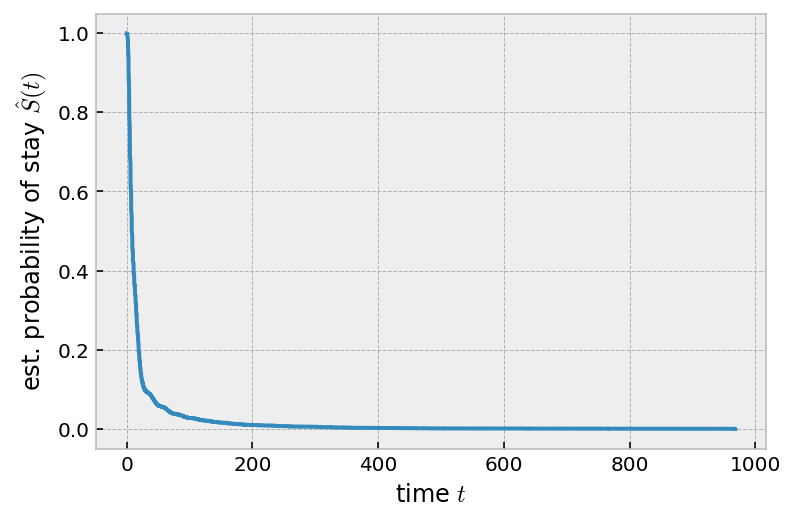

In [41]:
# view the data
time, survival_prob = kaplan_meier_estimator(y["Censor"], y["Survival"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of stay $\hat{S}(t)$")
plt.xlabel("time $t$")

(array([ 648., 2448., 1763.,  957.,  691., 1155.,  674.,  217.,   66.,
          81.,  132.]),
 array([ 0,  3,  6,  9, 12, 15, 20, 25, 30, 35, 40, 45]),
 <BarContainer object of 11 artists>)

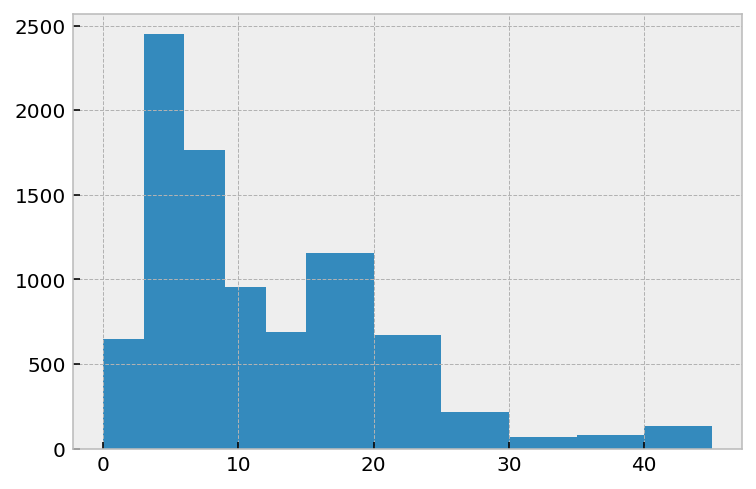

In [42]:
plt.hist(y["Survival"],bins=[0,3,6,9,12,15,20,25,30,*list(range(35,50,5))],range=(0,50))

## 2: DL Survival Analysis

### 2.1: Cox models

#### 2.1.1: CoxPH

C-index of Cox model: 0.6722124554378662
C-index of Cox model: 0.6832310016478013
C-index of Cox model: 0.6875147854232624


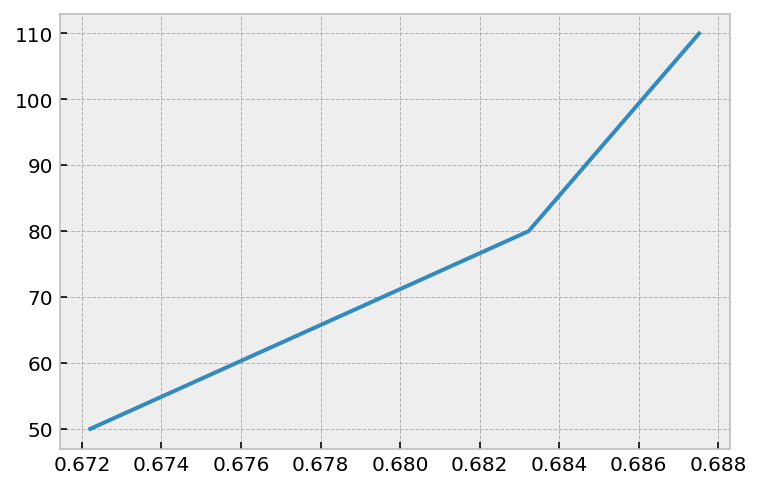

In [48]:
y_ = []
x_ = []
for i in list(range(50,140,30)):
    Xt = OneHotEncoder().fit_transform(X)
    how_many_select = i
    mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42), index=[*list(Xt.columns)])
    mutual_info_df = mutual_info_df.sort_values(by=[0])
    inc_var = list(mutual_info_df.index)[-how_many_select:]
    Xt = Xt[inc_var]
    cph = CoxPHSurvivalAnalysis()
    cph.fit(Xt, y)

    # get c-index of trained estimator
    pred = cph.predict(Xt)
    result = concordance_index_censored(y['Censor'], y["Survival"], pred)
    print('C-index of Cox model: '+str(result[0]))
    x_.append(i)
    y_.append(result[0])

plt.plot(y_,x_)

In [46]:
cph = CoxPHSurvivalAnalysis()
cph.fit(Xt, y)

# get c-index of trained estimator
pred = cph.predict(Xt)
result = concordance_index_censored(y['Censor'], y["Survival"], pred)
print('C-index of Cox model: '+str(result[0]))

C-index of Cox model: 0.6657148414410696


In [28]:
alphas = 10. ** np.linspace(-4,4,10)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

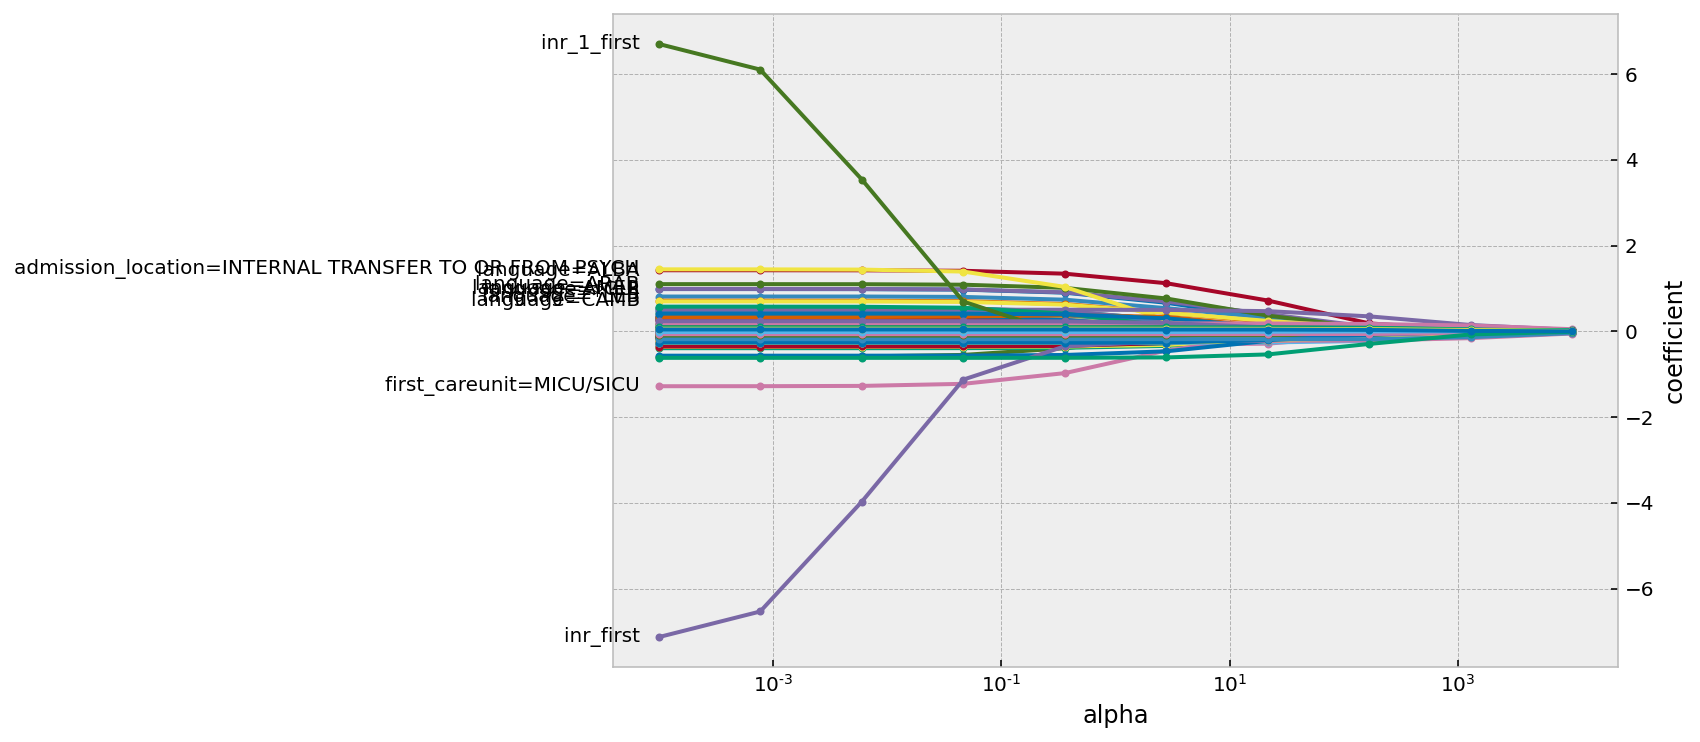

In [29]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
plot_coefficients(coefficients, n_highlight=10)

#### 2.1.2: Cox Elastic Net

In [30]:
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.9,
                                        max_iter=100))])

In [31]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

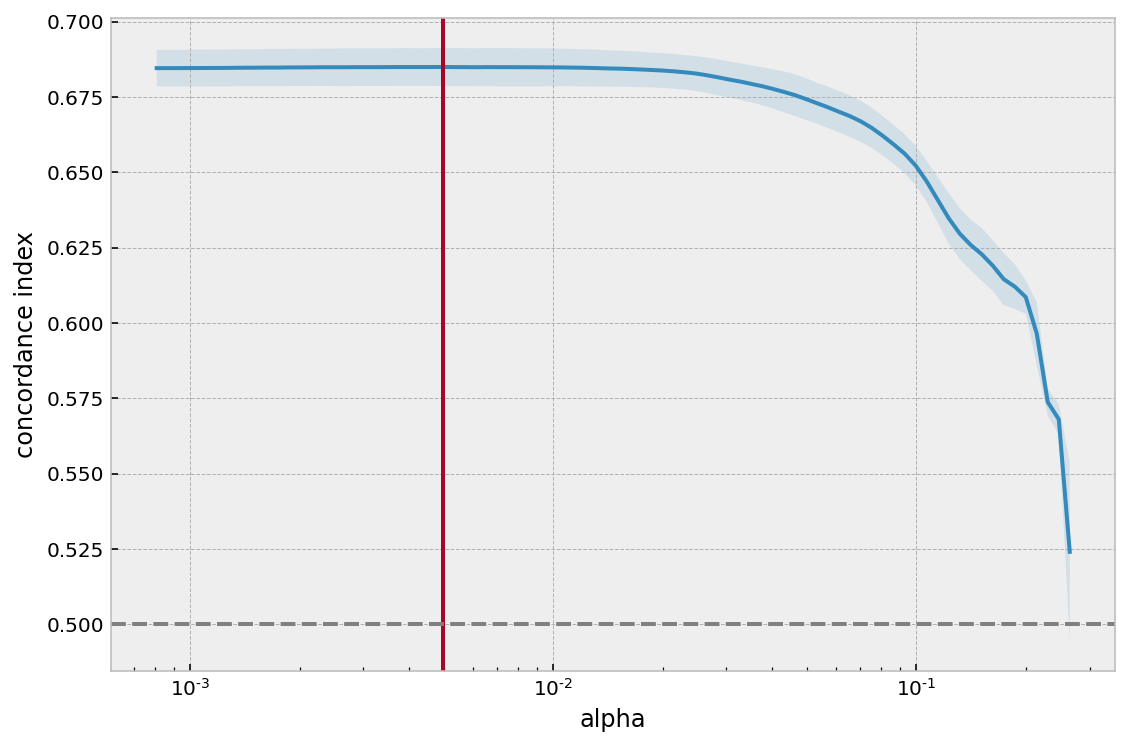

In [32]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 115


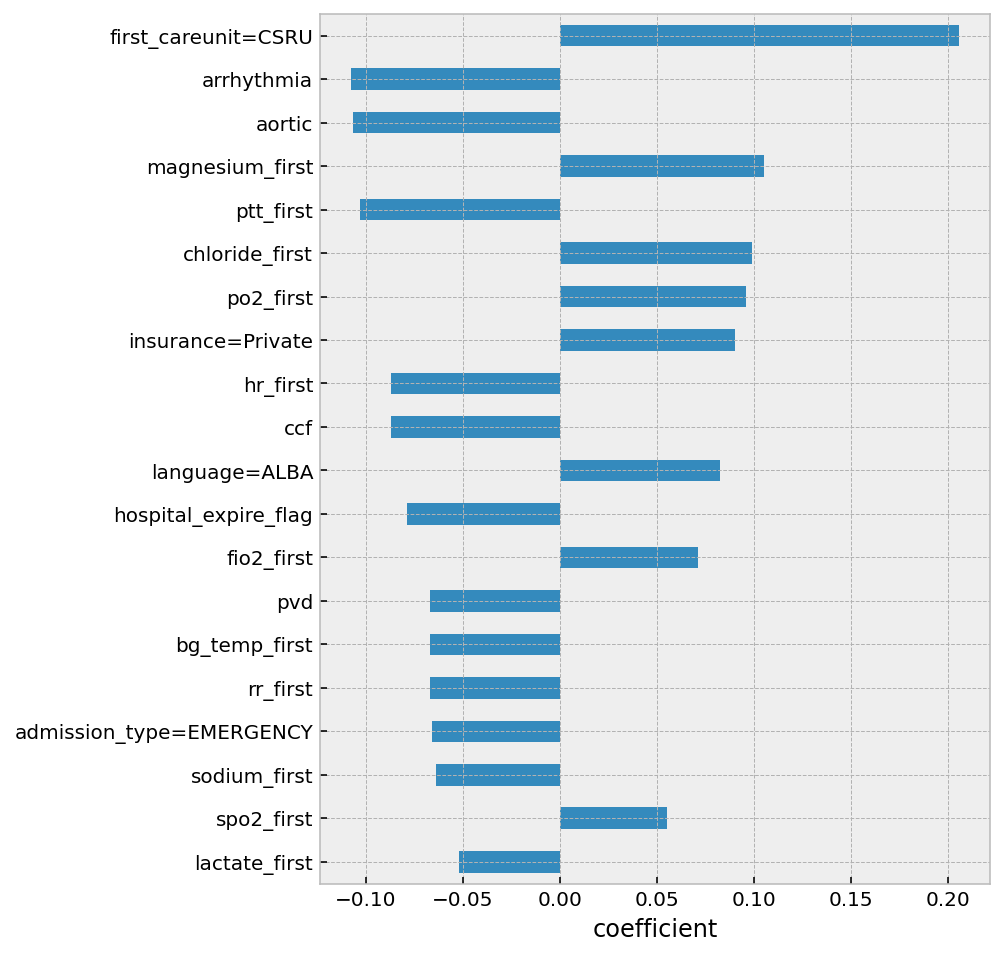

In [33]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xt.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order[-20:]].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

### 2.2: Random Survival Forest

In [34]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['duration1']
y

array([( True,  3. ), ( True,  3. ), ( True, 17.5), ..., ( True,  8. ),
       ( True, 12. ), ( True, 45. )],
      dtype=[('Censor', '?'), ('Survival', '<f8')])

In [35]:
random_state = 24

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.20, random_state=random_state)

In [36]:
rsf = RandomSurvivalForest(n_estimators=100,
                            min_samples_split=50,
                            min_samples_leaf=4,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=random_state)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)

0.696095983631265

In [19]:
rsf = RandomSurvivalForest()
parameters = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]}
rsf_tuned = RandomizedSearchCV(rsf, parameters, n_iter = 10, cv=3, n_jobs=-1, scoring='f1')
rsf_tuned.fit(X_train, y_train)
print ('Best parameters for RSF: {}'.format(rsf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rsf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rsf_tuned.predict(X_test))))

C:\Users\marcel\anaconda3\envs\tridentenv\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


MemoryError: could not allocate 281280512 bytes

In [ ]:
rsf = RandomSurvivalForest(n_estimators=200,
                            min_samples_split=50,
                            min_samples_leaf=3,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=random_state)
parameters = {'n_estimators': [100, 200],
              'max_features': ['auto'],
              'max_depth': [50, 100],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2,10],
              'bootstrap': [True, False]}
rsf_tuned = GridSearchCV(rsf, parameters, cv=5, n_jobs=-1, scoring='f1')
rsf_tuned.fit(X_train, y_train)
print ('Best parameters for RF: {}'.format(rf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rf_tuned.predict(x_test))))

In [ ]:
perm = PermutationImportance(rsf, n_iter=3, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

### 2.3: GBM Survival

In [53]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['duration1']
y

# get X_train, X_test, y_train, y_test
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

In [55]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    loss='ipcwls', n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

C:\Users\marcel\anaconda3\envs\tridentenv\lib\site-packages\sksurv\ensemble\boosting.py:943: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(10, 31,5):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + Xt.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

### 2.4: XGB

In [7]:
# models and metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgbse.metrics import concordance_index
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

# setting seed
np.random.seed(42)

# to easily plot confidence intervals

def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):
    
    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()

# to write data as markdown for publication

def df_to_markdown(df, float_format='%.2g'):
    """
    Export a pandas.DataFrame to markdown-formatted text.
    DataFrame should not contain any `|` characters.
    """
    from os import linesep
    df.columns = df.columns.astype(str)
    return linesep.join([
        '|'.join(df.columns),
        '|'.join(4 * '-' for i in df.columns),
        df.to_csv(sep='|', index=False, header=False, float_format=float_format)
    ]).replace('|', ' | ')

dtrain = xgb.DMatrix(Xt)
dtrain

## pre selected params for models ##

PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

PARAMS_XGB_COX = {
    'objective': 'survival:cox',
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50, 
    'colsample_bynode':0.5
}

PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist', 
    'max_depth': 100, 
    'booster':'dart', 
    'subsample': 1.0,
    'min_child_weight': 50, 
    'colsample_bynode': 1.0
}

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

N_NEIGHBORS = 50

TIME_BINS = np.arange(15, 315, 15)


C:\Users\marcel\AppData\Local\Temp/ipykernel_12704/2419616565.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [8]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y=convert_to_structured(df['duration1'],df['censor'])

# get X_train, X_test, y_train, y_test
(X_train, X_valid,
 y_train, y_valid) = \
train_test_split(Xt, y, test_size=0.2, random_state=42)

In [9]:
dtrain = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
dval = convert_data_to_xgb_format(X_valid, y_valid, 'survival:aft')

# training model
bst = xgb.train(
    PARAMS_XGB_AFT,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'val')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dval)
cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')
print(f"C-index: {cind:.3f}")
print(f"Average survival time: {preds.mean():.0f} days")

C-index: 0.685
Average survival time: 11 days


In [12]:
# saving predictions to plot later
preds_dict = {}

# loop to show different scale results
for scale in [1.0, 0.5, 0.25, 0.1]:
    
    # chaning parameter
    PARAMS_XGB_AFT['aft_loss_distribution_scale'] = scale
    
    # training model
    bst = xgb.train(
        PARAMS_XGB_AFT,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dval, 'val')],
        verbose_eval=0
    )

    # predicting and evaluating
    preds = bst.predict(dval)
    cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')

    preds_dict[scale] = preds

    print(f"aft_loss_distribution_scale: {scale}")
    print(f"C-index: {cind:.3f}")
    print(f"Average survival time: {preds.mean():.0f} days")
    print("----")

aft_loss_distribution_scale: 1.0
C-index: 0.685
Average survival time: 11 days
----
aft_loss_distribution_scale: 0.5
C-index: 0.689
Average survival time: 11 days
----
aft_loss_distribution_scale: 0.25
C-index: 0.689
Average survival time: 10 days
----
aft_loss_distribution_scale: 0.1
C-index: 0.681
Average survival time: 9 days
----


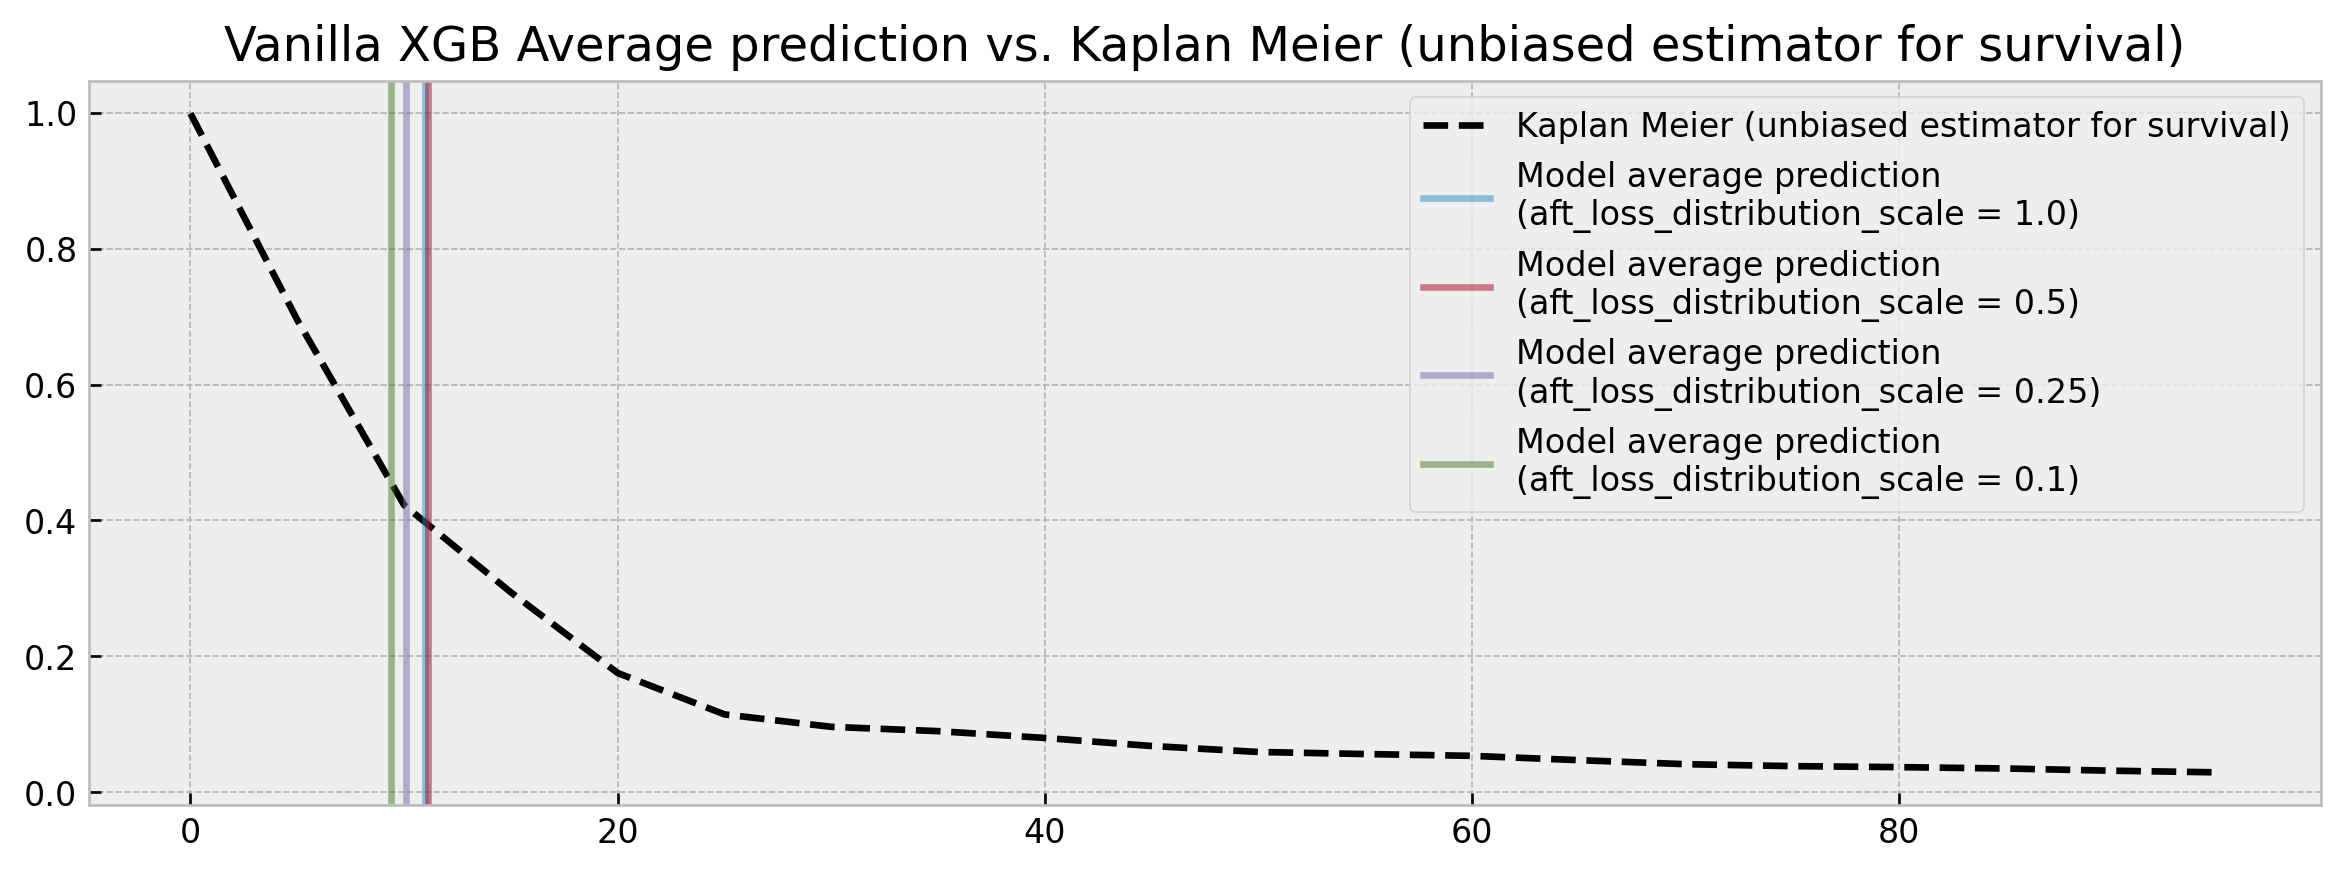

In [14]:
from xgbse.non_parametric import calculate_kaplan_vectorized

TIME_BINS = np.arange(0, 100, 5)

mean, high, low = calculate_kaplan_vectorized(
    y['c2'].reshape(1,-1),
    y['c1'].reshape(1,-1),
    TIME_BINS
)

plt.figure(figsize=(12,4), dpi=120)
plt.plot(mean.columns, mean.iloc[0], 'k--', label='Kaplan Meier (unbiased estimator for survival)')

for i, scale in enumerate([1.0, 0.5, 0.25, 0.1]):
    plt.axvline(
        preds_dict[scale].mean(),
        label=f'Model average prediction\n(aft_loss_distribution_scale = {scale})',
        linewidth=2, 
        alpha=0.5,
        color=f'C{i}'
    )

plt.title('Vanilla XGB Average prediction vs. Kaplan Meier (unbiased estimator for survival)')
plt.legend()

In [57]:
params = {'objective': 'survival:aft',
          'eval_metric': 'aft-nloglik',
          'aft_loss_distribution': 'normal',
          'aft_loss_distribution_scale': 1.20,
          'tree_method': 'hist', 'learning_rate': 0.05, 'max_depth': 2}
bst = xgb.train(params, dtrain, num_boost_round=1000,
                evals=[(dtrain, 'train')])
preds=bst.predict(dtrain)
cind=concordance_index(y)

[0]	train-aft-nloglik:6.42667
[1]	train-aft-nloglik:6.16055
[2]	train-aft-nloglik:5.92023
[3]	train-aft-nloglik:5.70314
[4]	train-aft-nloglik:5.50702
[5]	train-aft-nloglik:5.32962
[6]	train-aft-nloglik:5.16939
[7]	train-aft-nloglik:5.02470
[8]	train-aft-nloglik:4.89395
[9]	train-aft-nloglik:4.77563
[10]	train-aft-nloglik:4.66873
[11]	train-aft-nloglik:4.57212
[12]	train-aft-nloglik:4.48479
[13]	train-aft-nloglik:4.40570
[14]	train-aft-nloglik:4.33380
[15]	train-aft-nloglik:4.26921
[16]	train-aft-nloglik:4.21072
[17]	train-aft-nloglik:4.15777
[18]	train-aft-nloglik:4.10985
[19]	train-aft-nloglik:4.06654
[20]	train-aft-nloglik:4.02734
[21]	train-aft-nloglik:3.99180
[22]	train-aft-nloglik:3.95958
[23]	train-aft-nloglik:3.93031
[24]	train-aft-nloglik:3.90388
[25]	train-aft-nloglik:3.87996
[26]	train-aft-nloglik:3.85824
[27]	train-aft-nloglik:3.83839
[28]	train-aft-nloglik:3.82053
[29]	train-aft-nloglik:3.80431
[30]	train-aft-nloglik:3.78954
[31]	train-aft-nloglik:3.77640
[32]	train-aft-nlo

### 2.5: DCM

## 3: Exploring language and ventilation duration 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

dfImputed_onehot = dfImputed.copy()
dfImputed1 = pd.get_dummies(dfImputed_onehot, columns = ['ethnicity', 'language'], prefix = ['eth', 'lang'])
onehot_cols = [i for i in list(dfImputed1.columns) if i not in ['ethnicity', 'marital_status', 'language', 'admission_location']]
dfImputed1['duration1'] = df['duration1']
dfImputed1 = dfImputed1.dropna(axis=0, how='any')

In [ ]:
dfImputed1

In [ ]:
from matplotlib import pyplot
from scipy.stats import kstest, norm, pearsonr, ttest_ind

x = dfImputed1['lang_ENGL']
y = df['duration1'].dropna(axis=0,how='any')

#testing for normalcy
mu, std = norm.fit(x)
n = norm(loc=mu, scale=std)
normalcy_p = kstest(x, n.cdf)[1]
print('p-val: '+ str(normalcy_p))

pyplot.scatter(x,y)
covariance = np.cov(x,y)
print('Covariance matrix: ')
print(covariance)

#find pearson R
corr, _ = pearsonr(x,y)
print('Pearsons R: %.3f' %corr)

In [ ]:
import statsmodels.api as sm

univariable = pd.DataFrame(index = ['eth_white','lang_ENGL'], columns = ['OR (95% CI)','p-value'])

p_value = []
OR = []
time = []
for column in ['lang_ENGL']:
    for int_timelimit in range(0,48,1):
        X = dfImputed1[column].values
        X = sm.add_constant(X)
        y = pd.cut(df['duration1'].dropna(how='any'),bins=[-0.1,int_timelimit,4000],labels=[0,1])
        logit = sm.Logit(y, X)
        model = logit.fit(method='bfgs',disp = False)
        model_odds = pd.DataFrame(np.exp(model.params), columns=['OR'])
        model_odds['p-value'] = model.pvalues
        model_odds[['2.5%','97.5%']]= np.exp(model.conf_int())
        model_odds.rename(index={'x1': column}, inplace = True)
        # insert it into the dataframe 'univariable'
        univariable.at[column,'OR (95% CI)'] = '{OR:.3f} ({lower:.3f} to {upper:.3f})'.format(OR = model_odds.at[column, 'OR'], 
                                                                                            lower = model_odds.at[column, '2.5%'], 
                                                                                            upper = model_odds.at[column, '97.5%'])
        univariable.at[column,'p-value'] = '{0:.3f}'.format(model_odds.at[column, 'p-value'])
        p_value.append(model_odds.at[column, 'p-value'])
        OR.append(model_odds.at[column, 'OR'])
        time.append(int_timelimit)

univariable

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(time, OR, label='OR',color='blue')
ax.set_xlabel("ventilation time")
ax.set_ylabel("OR")

ax2=ax.twinx()
ax2.plot(time, p_value, label='p-val',color='orange')
ax2.set_ylabel("p-val")


In [ ]:
x1 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==1].dropna(axis=0,how='any')
x2 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==0].dropna(axis=0,how='any')
plt.hist(x1,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60))
plt.hist(x2,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60),color='orange')
print('mean English: '+str(np.mean(x1)))
print('mean non-English: '+str(np.mean(x2)))
print('t_test p-val;: '+str(ttest_ind(x1, x2)[1]))